# Project Overview

Assessing the effectiveness of energy efficiency improvements in buildings is a complex task. Since we cannot directly measure how much energy a building would have consumed without the upgrades, we rely on counterfactual models. These models estimate what the energy consumption would have been without the retrofit, allowing us to calculate the savings generated by energy efficiency measures. More accurate models can lead to improved market incentives and lower-cost financing for future upgrades.

## Objective

The goal of this project is to develop predictive models that estimate energy consumption in buildings before and after retrofits. The models will help evaluate the effectiveness of energy efficiency improvements across four energy types: electricity, chilled water, steam, and hot water. By improving the accuracy of these models, we can enable better financial decision-making and optimize energy efficiency investments.

## Dataset Description

The dataset consists of three years of hourly meter readings from over one thousand buildings located at various sites worldwide. It includes three key components:

1. Energy Consumption Data (train.csv)

   - building_id: Identifier for each building.

   - meter: Type of energy meter (0: electricity, 1: chilled water, 2: steam, 3: hot water).

   - timestamp: Date and time of the measurement.

   - meter_reading: Actual energy consumption (in kWh or equivalent).

Note: Data may contain measurement errors, setting a baseline level of modeling uncertainty.

2. Building Metadata (building_meta.csv)

   - site_id: Links buildings to weather data.

   - building_id: Links metadata to energy consumption data.

   - primary_use: Indicates the primary function of the building (e.g., office, hospital, retail, etc.).

   - square_feet: Total floor area of the building.

   - year_built: Year the building was constructed.

   - floor_count: Number of floors in the building.

3. Weather Data (weather_train.csv & weather_test.csv)

    Weather conditions from meteorological stations near the building sites:

   - site_id: Identifier linking weather data to buildings.

   - air_temperature: Temperature in degrees Celsius.

   - cloud_coverage: Sky cloud coverage in oktas.

   - dew_temperature: Dew point temperature in degrees Celsius.

   - precip_depth_1_hr: Rainfall in millimeters.

   - sea_level_pressure: Atmospheric pressure in millibars.

   - wind_direction: Wind direction in degrees (0-360).

   - wind_speed: Wind speed in meters per second.

## Methodology

To develop effective counterfactual models, we will employ the following machine learning techniques:

Data Preprocessing

Handle missing values in weather and building metadata.

Convert timestamps to meaningful features (e.g., hour, day of the week, seasonality).

Normalize and scale numeric features.

Feature Engineering

Model Selection and Training

Experiment with multiple machine learning algorithms:

Gradient Boosting Models (XGBoost, LightGBM, CatBoost): Handle non-linearity and feature interactions well.

Neural Networks: Capture complex temporal dependencies in energy consumption.

Train models on historical data and validate using recent data to ensure generalization.

Model Evaluation

Compare model predictions with actual post-retrofit energy usage.

Deployment & Interpretation

Deploy the best-performing model to estimate energy savings.

Provide insights on key factors influencing energy efficiency (e.g., weather conditions, building age, usage type).

Develop visualizations to communicate results effectively to stakeholders.

## Conclusion

This project aims to bridge the gap between real-world energy efficiency improvements and their financial viability. By leveraging machine learning, we can provide data-driven insights that support investment in sustainable energy practices, ultimately contributing to a more energy-efficient future.

## Imports

In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## EDA and pre-processing

In [3]:
train = pd.read_csv('data/train.csv')
building_metadata = pd.read_csv('data/building_metadata.csv')
weather = pd.read_csv('data/weather_train.csv')

In [4]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [6]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


#### **Step 1**: Merge between train and building_metadata

building_metadata contain building_id so we will merge on that first.

In [7]:
df = train.merge(building_metadata, on='building_id', how='left')


In [8]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


#### **Step 2**: Merge df with weather_train

The weather_train.csv dataset contains site_id and timestamp, so we need to merge using these keys.

We need to ensure timestamp is in datetime format before merging to avoid mismatches.

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


#### **Step 3**: Understanding the dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int64         
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 2.4+ GB


The memory usage of this dataset is quite large so we use a more memory-efficient data type:


In [11]:
# Downcast numerical columns to save memory
df['primary_use'] = df['primary_use'].astype('category') # This line is the more important one, it divide by 100 the memory used
df['building_id'] = df['building_id'].astype('int32')
df['meter'] = df['meter'].astype('int32')
df['site_id'] = df['site_id'].astype('int32')
df['square_feet'] = df['square_feet'].astype('int32')
df['year_built'] = df['year_built'].astype('float32')  
df['floor_count'] = df['floor_count'].astype('float32')
df['meter_reading'] = df['meter_reading'].astype('float32')
df['air_temperature'] = df['air_temperature'].astype('float32')
df['cloud_coverage'] = df['cloud_coverage'].astype('float32')
df['dew_temperature'] = df['dew_temperature'].astype('float32')
df['precip_depth_1_hr'] = df['precip_depth_1_hr'].astype('float32')
df['sea_level_pressure'] = df['sea_level_pressure'].astype('float32')
df['wind_direction'] = df['wind_direction'].astype('float32')
df['wind_speed'] = df['wind_speed'].astype('float32')

# Check the memory usage
print(df.memory_usage(deep=True))

Index                       132
building_id            80864400
meter                  80864400
timestamp             161728800
meter_reading          80864400
site_id                80864400
primary_use            20217659
square_feet            80864400
year_built             80864400
floor_count            80864400
air_temperature        80864400
cloud_coverage         80864400
dew_temperature        80864400
precip_depth_1_hr      80864400
sea_level_pressure     80864400
wind_direction         80864400
wind_speed             80864400
dtype: int64


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int32         
 1   meter               int32         
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int32         
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float32       
 8   floor_count         float32       
 9   air_temperature     float32       
 10  cloud_coverage      float32       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float32       
 13  sea_level_pressure  float32       
 14  wind_direction      float32       
 15  wind_speed          float32       
dtypes: category(1), datetime64[ns](1), float32(10), int32(4)
memory usage: 1.2 GB


In [13]:
print(df.shape)

(20216100, 16)


In [14]:
df.describe()

,building_id,meter,timestamp,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,20216100,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2016-07-03 22:59:40.301601792,2.117122e+03,7.992232e+00,1.077830e+05,1.968276e+03,4.184848e+00,1.598795e+01,1.900424e+00,7.747426e+00,7.964156e-01,1.016085e+03,1.730152e+02,3.377523e+00
min,0.000000e+00,0.000000e+00,2016-01-01 00:00:00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,2016-04-05 21:00:00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,2016-07-04 17:00:00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2016-10-02 22:00:00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2016-12-31 23:00:00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01
std,4.269133e+02,9.309921e-01,NaN,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00


#### **Step 4**: Null values

Next, we check if there are any null values in our dataset.

In [15]:
df.isnull().sum().sort_values(ascending=False)

floor_count           16709167
year_built            12127645
cloud_coverage         8825365
precip_depth_1_hr      3749023
wind_direction         1449048
sea_level_pressure     1231669
wind_speed              143676
dew_temperature         100140
air_temperature          96658
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
dtype: int64

We can see that a lot of our columns have missing values. We need to handle them properly because it could impact our model's performance later on.
The good news is that there are no missing values in our target variable: meter_reading.

In [16]:
display((df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False))

floor_count           82.652772
year_built            59.990033
cloud_coverage        43.655131
precip_depth_1_hr     18.544739
wind_direction         7.167792
sea_level_pressure     6.092515
wind_speed             0.710701
dew_temperature        0.495348
air_temperature        0.478124
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
dtype: float64

In [17]:
# we drop all the columns with more than 40% missing values

df = df.drop(['cloud_coverage', 'year_built', 'floor_count'], axis=1)

In [18]:
# fill missing values with knn imputer or mean for efficiency
from sklearn.impute import KNNImputer


df_numeric = df.select_dtypes(exclude=['object', 'datetime64[ns]','category']) 
df_non_numeric = df.select_dtypes(include=['object', 'datetime64[ns]', 'category'])  
# method = 'knn'
method = 'mean'

if method == 'knn':
    batch_size=1000
    knn_imputer = KNNImputer(n_neighbors=3)
    df_imputed_list=[]
    columns = df_numeric.columns 

    for i in range(0, len(df_numeric), batch_size):
        batch = df_numeric.iloc[i:i+batch_size]

        if batch.isnull().all().all():
            imputed_batch = batch.fillna(0).values 
        else:
            imputed_batch = knn_imputer.fit_transform(batch)

        df_imputed_list.append(pd.DataFrame(imputed_batch, columns=columns[:imputed_batch.shape[1]]))  

    df_imputed = pd.concat(df_imputed_list, axis=0).reset_index(drop=True)

    df_imputed = pd.concat(df_imputed_list, axis=0).reset_index(drop=True)

    # Add back the datetime column
    df_imputed['date'] = df['date'].values


elif method == 'mean': 
    df_imputed = df_numeric.fillna(df_numeric.mean())

df_final = pd.concat([df_imputed, df_non_numeric.reset_index(drop=True)], axis=1)
df=df_final
df.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestamp,primary_use
0,0,0,0.0,0,7432,25.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
1,1,0,0.0,0,2720,25.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
2,2,0,0.0,0,5376,25.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
3,3,0,0.0,0,23685,25.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education
4,4,0,0.0,0,116607,25.0,20.0,0.796416,1019.700012,0.0,0.0,2016-01-01,Education


In [19]:
df.isnull().sum().sort_values(ascending=False)

building_id           0
meter                 0
meter_reading         0
site_id               0
square_feet           0
air_temperature       0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
timestamp             0
primary_use           0
dtype: int64

#### **Step 5**: Check the duplicates

We also want to make sure there are no duplicates in the dataset.

In [20]:
df.shape

(20216100, 13)

In [21]:
df=df.drop_duplicates()

In [22]:
df.shape

(20216100, 13)

The number of rows hasn't changed so that means there were no duplicates.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int32         
 1   meter               int32         
 2   meter_reading       float32       
 3   site_id             int32         
 4   square_feet         int32         
 5   air_temperature     float32       
 6   dew_temperature     float32       
 7   precip_depth_1_hr   float32       
 8   sea_level_pressure  float32       
 9   wind_direction      float32       
 10  wind_speed          float32       
 11  timestamp           datetime64[ns]
 12  primary_use         category      
dtypes: category(1), datetime64[ns](1), float32(7), int32(4)
memory usage: 1021.8 MB


#### **Step 6**: Detect and replace the outliers

In this step, we identify and handle extreme values (aka outliers) in our dataset to keep things balanced. We use the Interquartile Range (IQR) method, which helps detect unusually high or low values that might alter or bias our analysis. Instead of removing these outliers (which could mean losing valuable data), we cap them by replacing values that fall outside the normal range with the closest acceptable limit (the 1st quartile or the 3rd). This ensures our data stays clean and reliable while preserving its overall structure.

In [24]:
outlier_cols = ['square_feet', 'air_temperature', 'dew_temperature', 
                'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

def replace_outliers(data):
    """Replace outliers in a pandas Series using the IQR method."""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data.apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

df[outlier_cols] = df[outlier_cols].apply(replace_outliers)

#### **Step 7**: Feature engineering

**Time Features**:

We want to separate the date from the time. This way it will be easier to manipulate the dataset when we want to analyse things hourly or daily or monthly.

For the hour, we only take the first part because the data is always taken at full hours like 9:00 or 21:00.

We also are decomposing the date into day, month and year which will make things easier when we need to filter data based on timestamps.

For the day, we also use dt.dayoftheweek to get a value depending on the date: 1 for Monday, 2 for Tuesday, etc. The specific day number (like the 10th or the 23rd) is not necessarily important. Something that would be more relevant is knowing if it is a Monday, Tuesday, etc., and then whether it's a weekday or weekend.
Once we have this, we can determine if the day is a week day or weekend: if the number is between 1 and 5 it's the week and if the number is 6 or 7, it's the weekend.

In [25]:
df['date']=df['timestamp'].dt.date.astype('datetime64[ns]')
df['hour'] = df['timestamp'].dt.hour
df['year']=df['timestamp'].dt.year
df['month']=df['timestamp'].dt.month
df['day']=df['timestamp'].dt.day
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df=df.drop('timestamp', axis=1)
df.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,primary_use,date,hour,year,month,day,dayofweek,is_weekend
0,0,0,0.0,0,7432.0,25.0,20.0,0.0,1019.700012,0.0,0.0,Education,2016-01-01,0,2016,1,1,4,0
1,1,0,0.0,0,2720.0,25.0,20.0,0.0,1019.700012,0.0,0.0,Education,2016-01-01,0,2016,1,1,4,0
2,2,0,0.0,0,5376.0,25.0,20.0,0.0,1019.700012,0.0,0.0,Education,2016-01-01,0,2016,1,1,4,0
3,3,0,0.0,0,23685.0,25.0,20.0,0.0,1019.700012,0.0,0.0,Education,2016-01-01,0,2016,1,1,4,0
4,4,0,0.0,0,116607.0,25.0,20.0,0.0,1019.700012,0.0,0.0,Education,2016-01-01,0,2016,1,1,4,0


**Seasonal Features**: Consumption is affected by weather and seasonality. We can create a season column based on month:

In [26]:
def get_season(month):
    if month in [12, 1, 2]:  return 'winter'
    elif month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    else: return 'fall'

df['season'] = df['month'].apply(get_season)


**Temperature-Based Features**: If air_temperature affects usage, define hot vs cold days:

In [27]:
df['is_hot_day'] = (df['air_temperature'] > df['air_temperature'].quantile(0.75)).astype(int)
df['is_cold_day'] = (df['air_temperature'] < df['air_temperature'].quantile(0.25)).astype(int)


#### **Step 8**: Ensuring there are no negative values in the target variable
Now we also want to make sure there are no negative meter readings as that would be impossible.

In [28]:
print(df['meter_reading'].describe())

count    2.021610e+07
mean     2.117122e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64


In [29]:
print(df['meter_reading'].min())

0.0


We can see that the minimum value is 0.0 so there are no mistakes.

#### **Step 9**: Time Cyclic Encoding

We will use Time Cyclic Encoding using sine and cosine transformations to handle the cyclical nature of the time-based features such as hour, dayofweek and month.

Many machine learning models (like linear regression and tree-based models) assume that values have a linear relationship meaning that larger values are more important. But time-based variables don't behave that way. For example, the hour feature goes from 0 to 23, but 23:00 is just one hour away from 0:00 (midnight), which is not far apart. Similarly, dayofweek runs from 0 (Monday) to 6 (Sunday), but Sunday (6) is right next to Monday (0).

If we just feed these numbers into a model, it might think that 23 is much bigger than 0, when in reality, they are close in time. To fix this, we use sine and cosine transformations to map these values onto a circular space. By doing this, values that are close in time remain close mathematically (e.g., hour 23 and hour 0 will have similar encoded values) and the model will capture cyclical patterns more effectively.

In [30]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [31]:
df.head()

,building_id,meter,meter_reading,site_id,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,is_weekend,season,is_hot_day,is_cold_day,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,0,0,0.0,0,7432.0,25.0,20.0,0.0,1019.700012,0.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
1,1,0,0.0,0,2720.0,25.0,20.0,0.0,1019.700012,0.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
2,2,0,0.0,0,5376.0,25.0,20.0,0.0,1019.700012,0.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
3,3,0,0.0,0,23685.0,25.0,20.0,0.0,1019.700012,0.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
4,4,0,0.0,0,116607.0,25.0,20.0,0.0,1019.700012,0.0,...,0,winter,1,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025


## Visualizations

### 1-General Consumption Trends and Correlations

**Overall Energy Consumption Over Time**

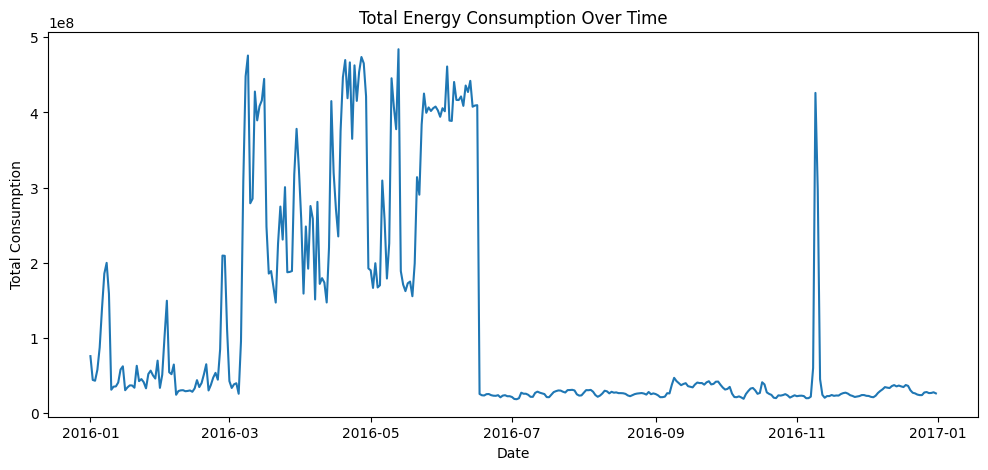

In [42]:
df_daily = df.groupby('date')['meter_reading'].sum().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_daily['date'], y=df_daily['meter_reading'])
plt.title('Total Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.show()

**Hourly Energy Consumption by Building Type**

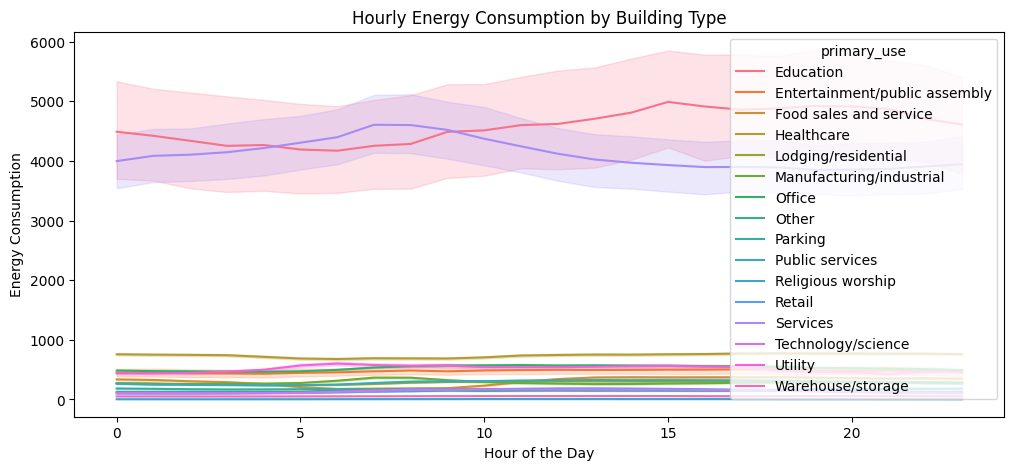

In [43]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['hour'], y=df['meter_reading'], hue=df['primary_use'], estimator='mean')
plt.title('Hourly Energy Consumption by Building Type')
plt.xlabel('Hour of the Day')
plt.ylabel('Energy Consumption')
plt.show()

**Average Energy Consumption in a Day**

C:\Users\DELL\AppData\Local\Temp\ipykernel_5636\2513089811.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)


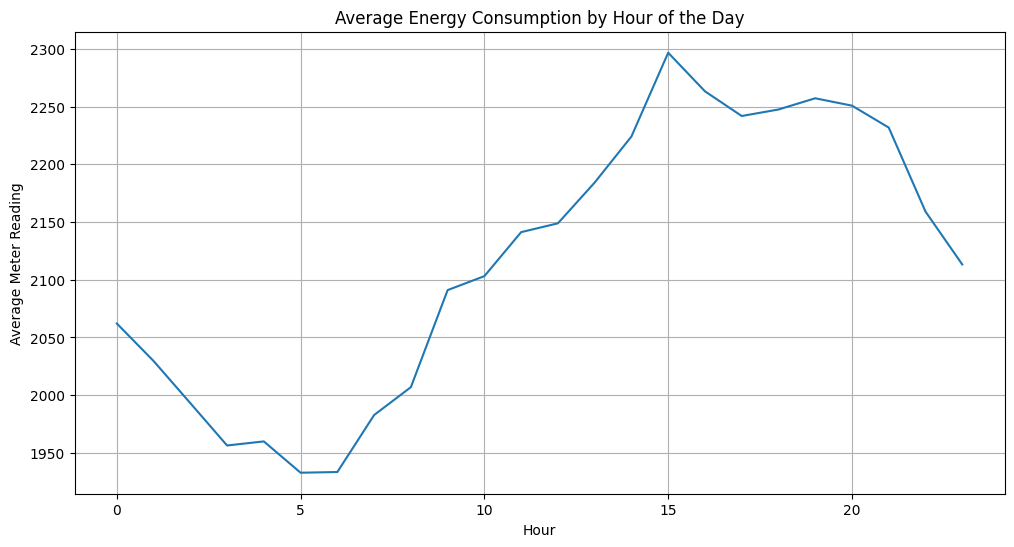

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)
plt.title('Average Energy Consumption by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Meter Reading')
plt.grid()
plt.show()


**Monthly Energy Consumption**

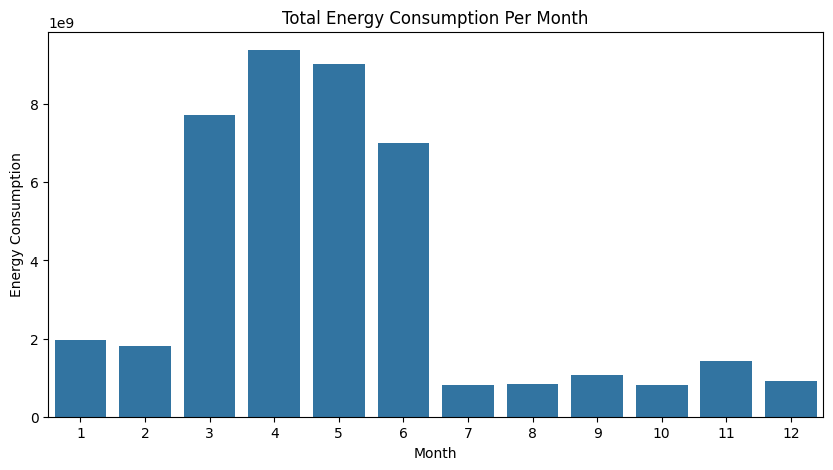

In [44]:
df_monthly = df.groupby('month')['meter_reading'].sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=df_monthly['month'], y=df_monthly['meter_reading'])
plt.title('Total Energy Consumption Per Month')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.show()

**Daily Energy Consumption Per Primary Use**

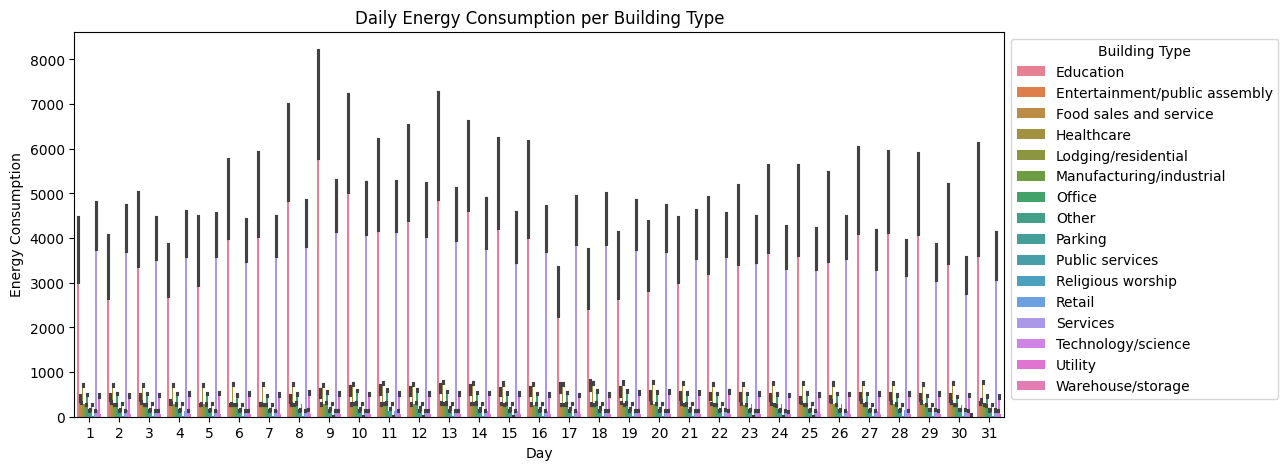

In [45]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df['day'], y=df['meter_reading'], hue=df['primary_use'])
plt.title('Daily Energy Consumption per Building Type')
plt.xlabel('Day')
plt.ylabel('Energy Consumption')
plt.legend(title="Building Type", bbox_to_anchor=(1, 1))
plt.show()

**Total Energy Consumption by Energy Source**

C:\Users\DELL\AppData\Local\Temp\ipykernel_5636\1207286170.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}),


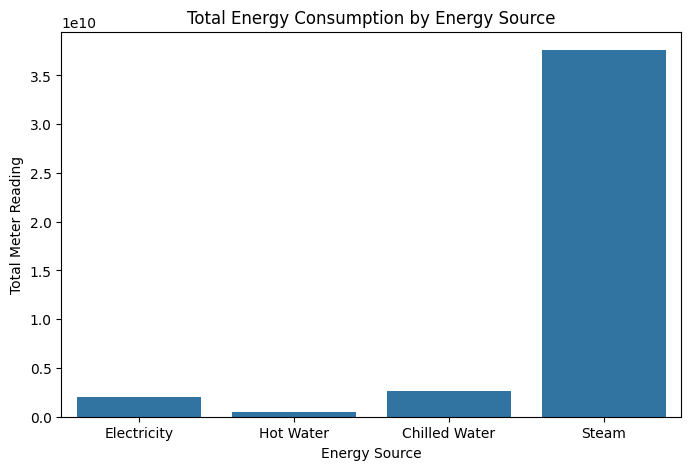

In [33]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}), 
            y=df['meter_reading'], estimator=sum, ci=None)
plt.title('Total Energy Consumption by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Total Meter Reading')
plt.show()


**Correlation Heatmap**

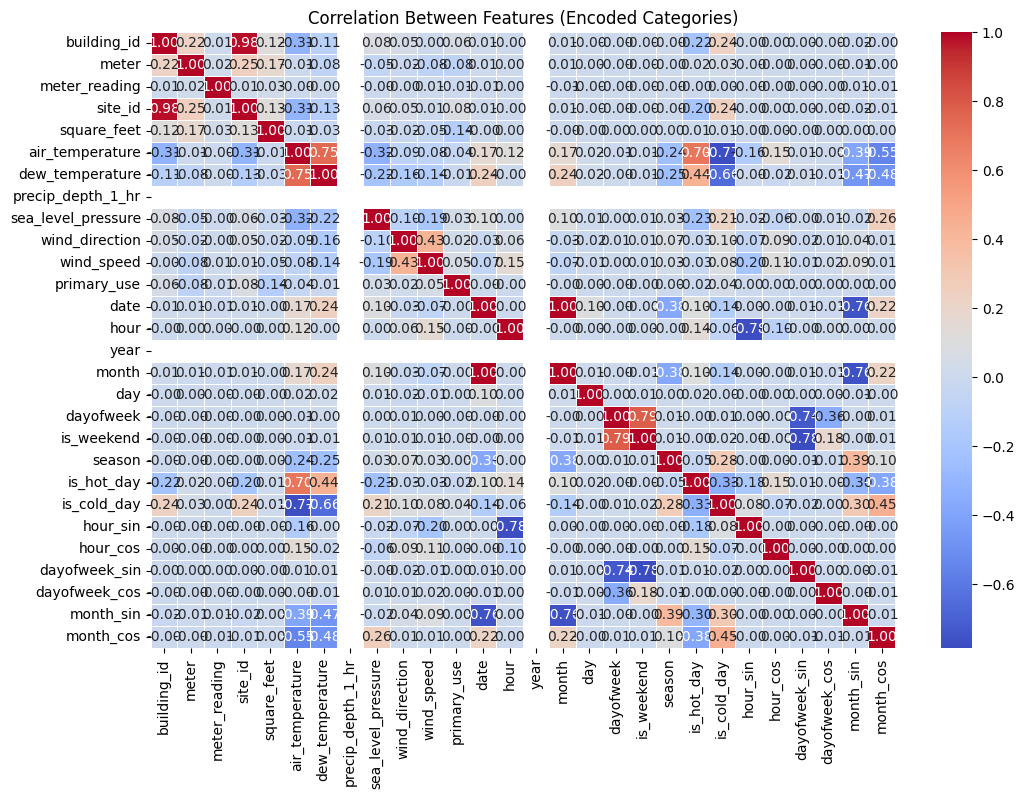

In [50]:
df_encoded = df.copy()
label_encoders = {}

for col in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Features (Encoded Categories)')
plt.show()

### 2-Weather Impact on Energy Consumption

**Temperature vs. Energy Consumption**

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



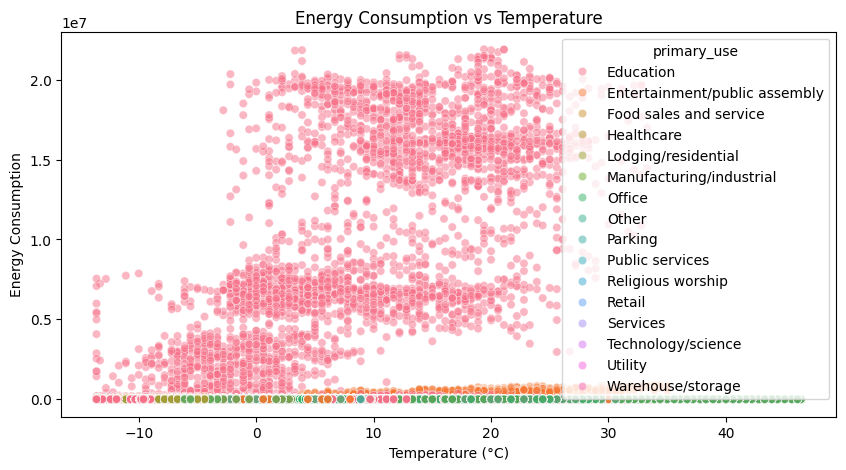

In [51]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['air_temperature'], y=df['meter_reading'], hue=df['primary_use'], alpha=0.5)
plt.title('Energy Consumption vs Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Energy Consumption')
plt.show()


**Precipitation Impact on Energy Consumption**

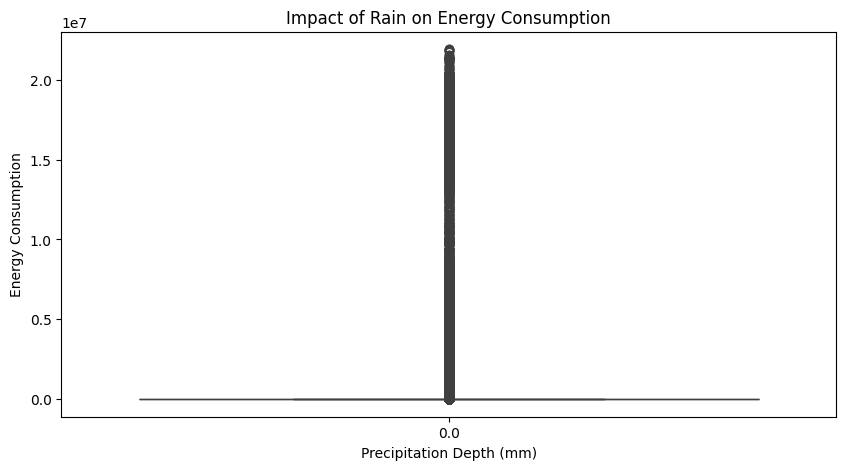

In [52]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['precip_depth_1_hr'], y=df['meter_reading'])
plt.title('Impact of Rain on Energy Consumption')
plt.xlabel('Precipitation Depth (mm)')
plt.ylabel('Energy Consumption')
plt.show()


**Wind Speed vs. Energy Usage**

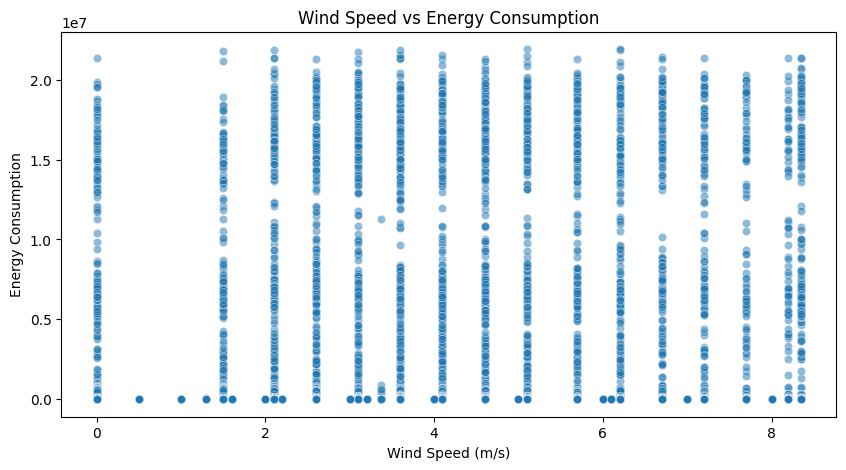

In [53]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['wind_speed'], y=df['meter_reading'], alpha=0.5)
plt.title('Wind Speed vs Energy Consumption')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Energy Consumption')
plt.show()


### 3-Building-Level Analysis

**Top 10 Buildings with the Highest Energy Consumption**

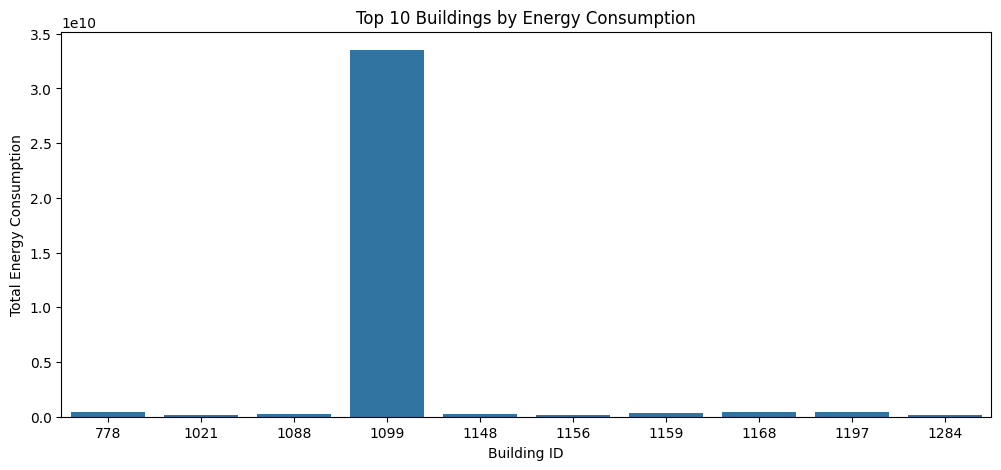

In [54]:
top_10_buildings = df.groupby('building_id')['meter_reading'].sum().nlargest(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_10_buildings.index, y=top_10_buildings.values)
plt.title('Top 10 Buildings by Energy Consumption')
plt.xlabel('Building ID')
plt.ylabel('Total Energy Consumption')
plt.show()


**Energy Consumption by Square Feet**

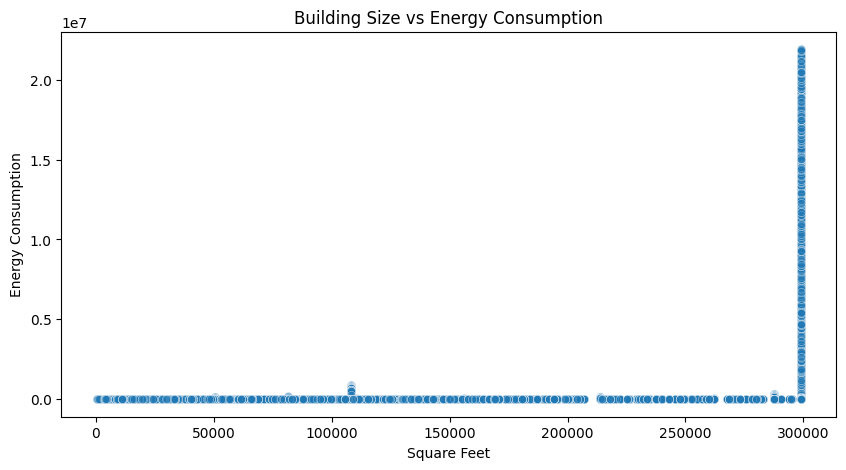

In [55]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['square_feet'], y=df['meter_reading'], alpha=0.5)
plt.title('Building Size vs Energy Consumption')
plt.xlabel('Square Feet')
plt.ylabel('Energy Consumption')
plt.show()


**Consumption Patterns by Building Id with their Primary Use**

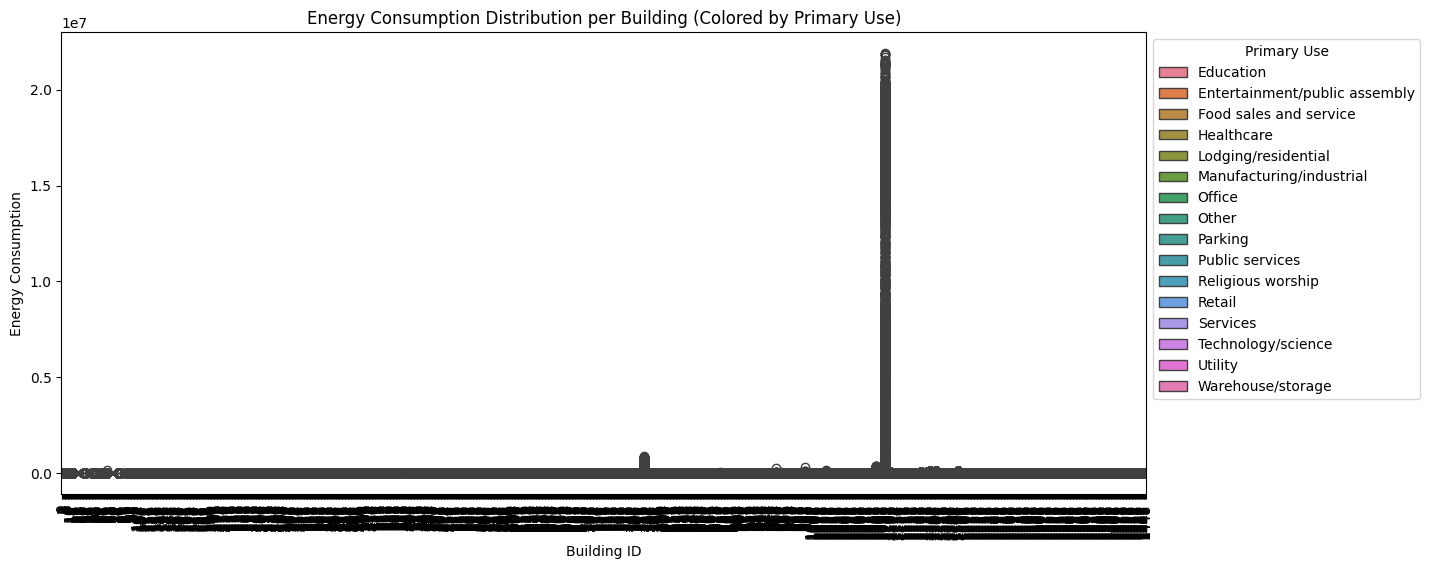

In [56]:
plt.figure(figsize=(14, 6))
sns.boxplot(x=df['building_id'], y=df['meter_reading'], hue=df['primary_use'])
plt.xticks(rotation=90)
plt.title('Energy Consumption Distribution per Building (Colored by Primary Use)')
plt.xlabel('Building ID')
plt.ylabel('Energy Consumption')
plt.legend(title='Primary Use', bbox_to_anchor=(1, 1)) 
plt.show()

### 4-Time-Based Energy Consumption Patterns

**Hourly Consumption by Day of the Week**

C:\Users\DELL\AppData\Local\Temp\ipykernel_5636\333979259.py:1: FutureWarning:

The provided callable <function mean at 0x00000234ED644720> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.



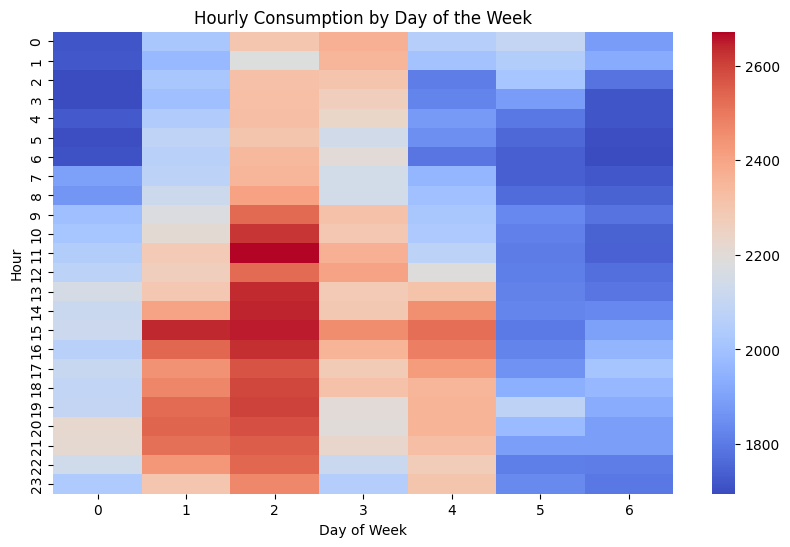

In [57]:
pivot_table = df.pivot_table(index='hour', columns='dayofweek', values='meter_reading', aggfunc=np.mean)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='coolwarm')
plt.title('Hourly Consumption by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()


**Weekend vs. WeekDay Consumption**

KeyboardInterrupt: 

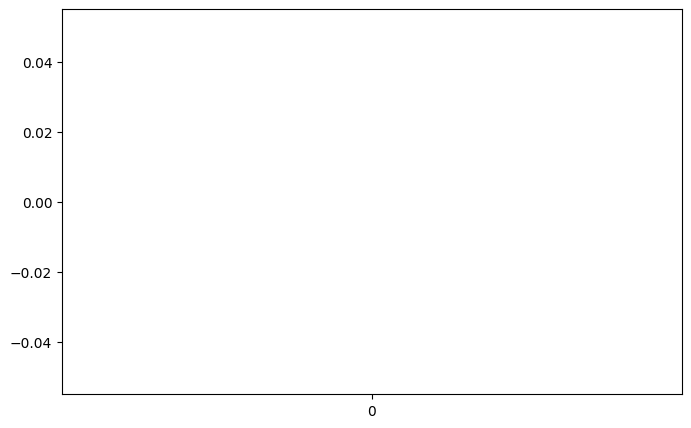

In [58]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['is_weekend'], y=df['meter_reading'])
plt.title('Energy Consumption: Weekday vs Weekend')
plt.xlabel('Weekend (0=No, 1=Yes)')
plt.ylabel('Energy Consumption')
plt.show()


**Seasonal Energy Usage Trends**

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['season'], y=df['meter_reading'], estimator='mean')
plt.title('Energy Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Energy Consumption')
plt.show()


## Analysis

blabla

## MODELS

In [ ]:
# very simple model to predict the meter_reading
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df[['square_feet', 'air_temperature', 'dew_temperature', 'hour', 'dayofweek', 'month', 'is_weekend']]
y = df['meter_reading']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
